## Video Frames Preparation

In [2]:
# !rm -rf /content/frames
# !tar -czvf frames.tar.gz /content/frames
# extract compressed content
# tar -xzvf archive.tar.gz -C /tmp

In [3]:
# import cv2
# import operator
# import numpy as np
# import matplotlib.pyplot as plt
# import sys
# from scipy.signal import argrelextrema 

# print(sys.executable)
# #Video path of the source file
# videopath = "/content/tvb_meiweiqingyuan_1.mp4"
# #Directory to store the processed frames
# dir = "/content/frames"
# #Class to hold information about each frame
# class Frame:
#     def __init__(self, id, frame, value):
#         self.id = id
#         self.frame = frame
#         self.value = value

#     def __lt__(self, other):
#         if self.id == other.id:
#             return self.id < other.id
#         return self.id < other.id

#     def __gt__(self, other):
#         return other.__lt__(self)

#     def __eq__(self, other):
#         return self.id == other.id and self.id == other.id

#     def __ne__(self, other):
#         return not self.__eq__(other)

# print("Video :" + videopath)
# print("Frame Directory: " + dir)
# cap = cv2.VideoCapture(str(videopath))

# curr_frame = None
# prev_frame = None

# ret, frame = cap.read()
# i = 1
# j = 1
# while(ret):
#     luv = cv2.cvtColor(frame, cv2.COLOR_BGR2LUV)
#     curr_frame = luv
#     if curr_frame is not None and prev_frame is not None:
#         #logic here
#         diff = cv2.absdiff(curr_frame, prev_frame)
#         count = np.sum(diff)
#         frame = Frame(j, frame, count)
#         if i%50 == 0:
#           j += 1
#           name = "frame_" + str(frame.id) + ".jpg"
#           cv2.imwrite(dir + "/" + name, frame.frame)
#     prev_frame = curr_frame
#     i = i + 1
#     ret, frame = cap.read()
# """
#     cv2.imshow('frame',luv)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
# """
# cap.release()
# #cv2.destroyAllWindows()

## Real Stuff Begin

## Libraries

In [2]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import numpy as np
# from scipy import ndimage

# from google.colab import drive
# drive.mount('/content/drive')
# import os
# import matplotlib.pyplot as plt

## Automatically Download Scenes From Videos Your Favorite Actor Appears 

### Classify whether you favorite actor appears in a scene from a Video

In [7]:
'''
/**
  1. Most of the code is from https://keras.io/examples/vision/image_classification_from_scratch/.
  2. The most significant difference is that I adopt transfer learning.
*/
'''

'\n/**\n  1. Most of the code is from https://keras.io/examples/vision/image_classification_from_scratch/.\n  2. The difference is that I adopt transfer learning.\n*/\n'

In [2]:
DATASET_FOLDER = "/content/drive/MyDrive/ML/CV/DATASET/Mei_Wei_Qing_Yuan/Actors_Images"

num_skipped = 0
for folder_name in ("Ma_You", "Others"):
    folder_path = os.path.join(DATASET_FOLDER, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split=0.3,
    subset="training",
    class_names=["Others", "Ma_You"],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_FOLDER,
    validation_split=0.3,
    subset="validation",
    class_names=["Others", "Ma_You"],
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1231 files belonging to 2 classes.
Using 862 files for training.
Found 1231 files belonging to 2 classes.
Using 369 files for validation.


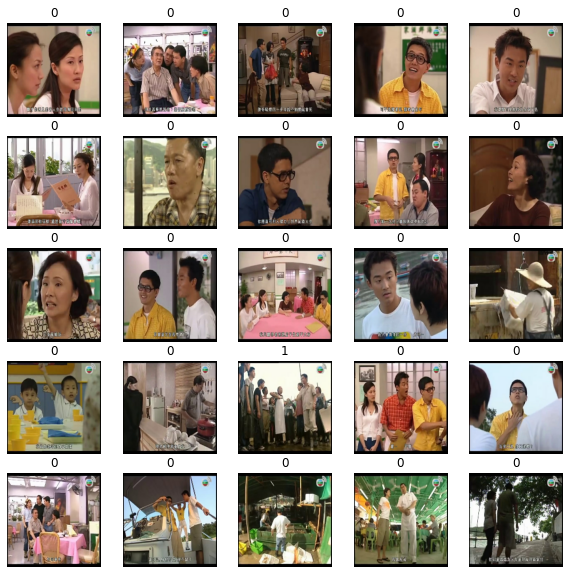

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

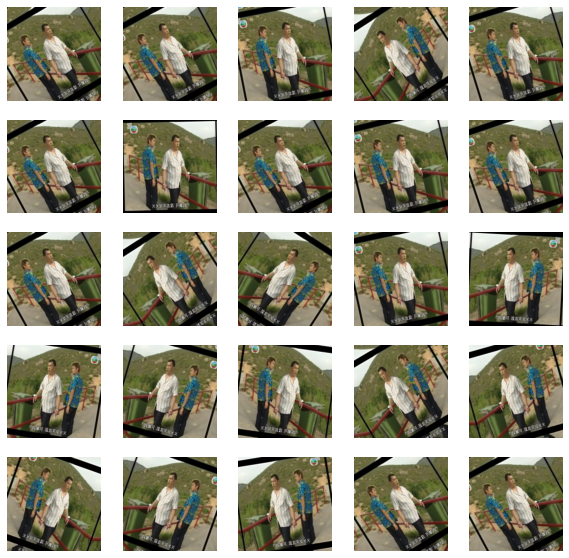

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(25):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [5]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [6]:
'''
/**
  You can reference this article to learn how to use the transfer learning:
  https://keras.io/guides/transfer_learning/
*/
'''
Xception = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(image_size + (3,)),
    include_top=False
)

Xception.trainable = False

83697664/83683744 [==============================] - 0s 0us/step


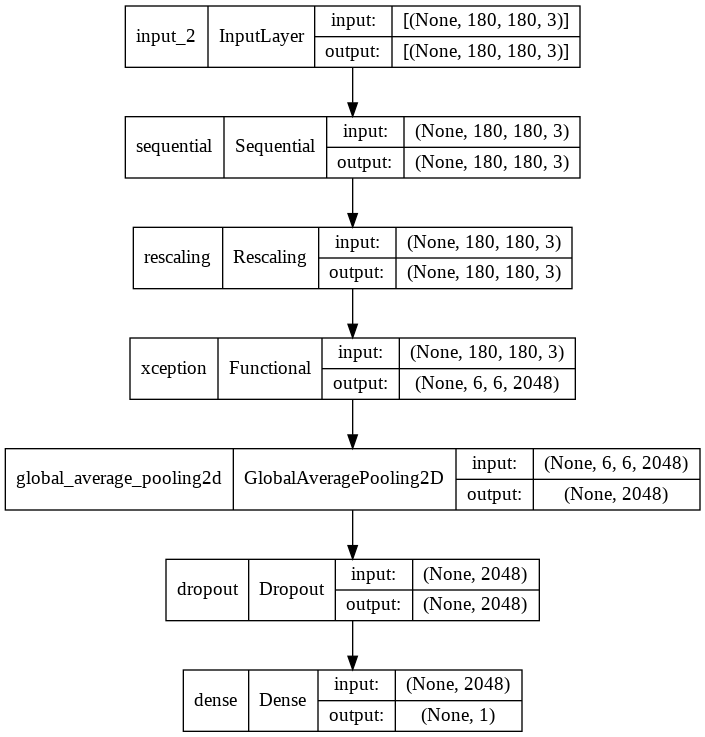

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    
    # Go through pretrained Xception model
    x = Xception(x, training=False)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    model = keras.Model(inputs, outputs)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [8]:
# epochs = 20

# callbacks = [
    
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=["accuracy", keras.metrics.PrecisionAtRecall(0.80) ],
# )
# model.fit(
#     train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight={0:1.0, 1:10.0}
# )

Epoch 1/20
27/27 [==============================] - 26s 450ms/step - loss: 1.0659 - accuracy: 0.8550 - precision_at_recall: 0.0619 - val_loss: 0.5530 - val_accuracy: 0.8022 - val_precision_at_recall: 0.0600
Epoch 2/20
27/27 [==============================] - 10s 334ms/step - loss: 0.9052 - accuracy: 0.8086 - precision_at_recall: 0.0738 - val_loss: 0.4019 - val_accuracy: 0.9241 - val_precision_at_recall: 0.1091
Epoch 3/20
27/27 [==============================] - 10s 345ms/step - loss: 0.7265 - accuracy: 0.8434 - precision_at_recall: 0.1863 - val_loss: 0.3784 - val_accuracy: 0.9106 - val_precision_at_recall: 0.0960
Epoch 4/20
27/27 [==============================] - 10s 333ms/step - loss: 0.6532 - accuracy: 0.9107 - precision_at_recall: 0.1306 - val_loss: 0.4010 - val_accuracy: 0.8835 - val_precision_at_recall: 0.1519
Epoch 5/20
27/27 [==============================] - 10s 347ms/step - loss: 0.6072 - accuracy: 0.8840 - precision_at_recall: 0.2000 - val_loss: 0.3144 - val_accuracy: 0.9295

In [9]:
# epochs = 20

# callbacks = [
    
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(0.0005),
#     loss=tf.keras.losses.BinaryCrossentropy(),
#     metrics=["accuracy", keras.metrics.PrecisionAtRecall(0.70) ],
# )
# model.fit(
#     train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds, class_weight={0:1.0, 1:10.0}
# )

Epoch 1/20
27/27 [==============================] - 15s 386ms/step - loss: 0.4266 - accuracy: 0.9397 - precision_at_recall_1: 0.5893 - val_loss: 0.2210 - val_accuracy: 0.9485 - val_precision_at_recall_1: 0.6471
Epoch 2/20
27/27 [==============================] - 10s 348ms/step - loss: 0.4009 - accuracy: 0.9246 - precision_at_recall_1: 0.7021 - val_loss: 0.2199 - val_accuracy: 0.9512 - val_precision_at_recall_1: 0.6875
Epoch 3/20
27/27 [==============================] - 10s 334ms/step - loss: 0.3678 - accuracy: 0.9455 - precision_at_recall_1: 0.6600 - val_loss: 0.2084 - val_accuracy: 0.9539 - val_precision_at_recall_1: 0.6875
Epoch 4/20
27/27 [==============================] - 10s 346ms/step - loss: 0.3294 - accuracy: 0.9350 - precision_at_recall_1: 0.7674 - val_loss: 0.2324 - val_accuracy: 0.9350 - val_precision_at_recall_1: 0.6875
Epoch 5/20
27/27 [==============================] - 10s 333ms/step - loss: 0.3626 - accuracy: 0.9316 - precision_at_recall_1: 0.7857 - val_loss: 0.2307 - va

In [9]:
Ma_You_classify_model_save_path = os.path.join(DATASET_FOLDER, 'Ma_You_classify_model')
## model.save_weights(filepath=Ma_You_classify_model_save_path)

In [10]:
model.load_weights(filepath=Ma_You_classify_model_save_path)

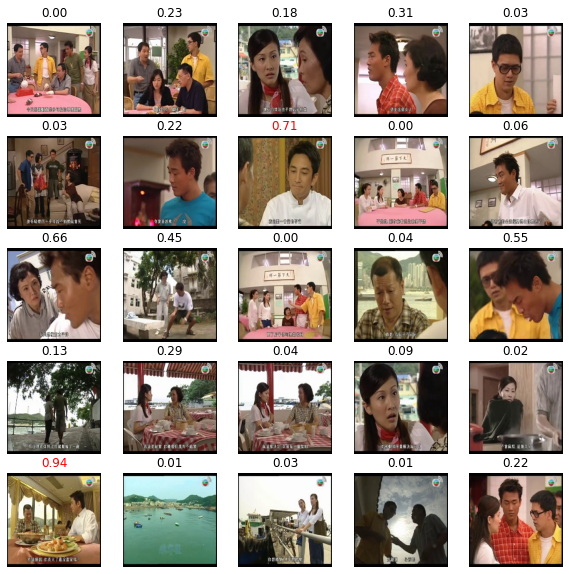

In [32]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    for i in range(25):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      title_obj = plt.title("%.2f"%predictions[i][0])    
      if labels[i] == 1:      
        plt.setp(title_obj, color='r')   
      plt.axis("off")

In [55]:
# precisions = []
# for threshold in range(11):
#   precision = keras.metrics.Precision(thresholds=threshold/10)
#   for images, labels in val_ds:
#     predictions = model.predict(images)[:, 0]
#     precision.update_state(labels, predictions)
#   precisions.append(precision.result().numpy())

In [56]:
precisions

[0.040650405,
 0.08383234,
 0.14,
 0.22222222,
 0.3611111,
 0.46153846,
 0.5714286,
 0.6875,
 0.75,
 0.6666667,
 0.0]

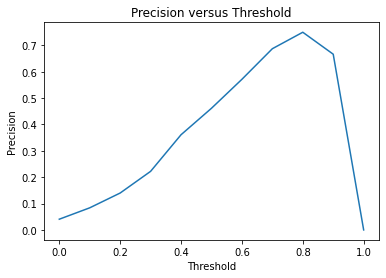

In [82]:
thresholds = np.array(range(11))/10
plt.plot(thresholds, precisions)
plt.title("Precision versus Threshold")
plt.ylabel("Precision")
plt.xlabel("Threshold")
plt.show()

In [89]:
'''
/**
Using Integrated Gradients to explain how the model see the scene containing Ma You.
Code referenced from https://keras.io/examples/vision/integrated_gradients/. 
*/
'''
Ma_You_in_Val = []
for images, labels in val_ds:
  for i, label in enumerate(labels):
    if label == 1:
      Ma_You_in_Val.append(images[i].numpy().astype("uint8"))

In [121]:
def get_img_array(img):
    array = np.expand_dims(img, axis=0)
    return array

def get_gradients(img_input):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)

    grads = tape.gradient(preds, images)
    return grads


def get_integrated_gradients(img_input, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(image_size+(3,)).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads


def random_baseline_integrated_gradients(
    img_input, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(image_size+(3,)) * 255
        igrads = get_integrated_gradients(
            img_input=img_input,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

class GradVisualizer:
    """Plot gradients of the outputs w.r.t an input image."""

    def __init__(self, positive_channel=None, negative_channel=None):
        if positive_channel is None:
            self.positive_channel = [0, 255, 0]
        else:
            self.positive_channel = positive_channel

        if negative_channel is None:
            self.negative_channel = [255, 0, 0]
        else:
            self.negative_channel = negative_channel

    def apply_polarity(self, attributions, polarity):
        if polarity == "positive":
            return np.clip(attributions, 0, 1)
        else:
            return np.clip(attributions, -1, 0)

    def apply_linear_transformation(
        self,
        attributions,
        clip_above_percentile=99.9,
        clip_below_percentile=70.0,
        lower_end=0.2,
    ):
        # 1. Get the thresholds
        m = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_above_percentile
        )
        e = self.get_thresholded_attributions(
            attributions, percentage=100 - clip_below_percentile
        )

        # 2. Transform the attributions by a linear function f(x) = a*x + b such that
        # f(m) = 1.0 and f(e) = lower_end
        transformed_attributions = (1 - lower_end) * (np.abs(attributions) - e) / (
            m - e
        ) + lower_end

        # 3. Make sure that the sign of transformed attributions is the same as original attributions
        transformed_attributions *= np.sign(attributions)

        # 4. Only keep values that are bigger than the lower_end
        transformed_attributions *= transformed_attributions >= lower_end

        # 5. Clip values and return
        transformed_attributions = np.clip(transformed_attributions, 0.0, 1.0)
        return transformed_attributions

    def get_thresholded_attributions(self, attributions, percentage):
        if percentage == 100.0:
            return np.min(attributions)

        # 1. Flatten the attributions
        flatten_attr = attributions.flatten()

        # 2. Get the sum of the attributions
        total = np.sum(flatten_attr)

        # 3. Sort the attributions from largest to smallest.
        sorted_attributions = np.sort(np.abs(flatten_attr))[::-1]

        # 4. Calculate the percentage of the total sum that each attribution
        # and the values about it contribute.
        cum_sum = 100.0 * np.cumsum(sorted_attributions) / total

        # 5. Threshold the attributions by the percentage
        indices_to_consider = np.where(cum_sum >= percentage)[0][0]

        # 6. Select the desired attributions and return
        attributions = sorted_attributions[indices_to_consider]
        return attributions

    def binarize(self, attributions, threshold=0.001):
        return attributions > threshold

    def morphological_cleanup_fn(self, attributions, structure=np.ones((4, 4))):
        closed = ndimage.grey_closing(attributions, structure=structure)
        opened = ndimage.grey_opening(closed, structure=structure)
        return opened

    def draw_outlines(
        self, attributions, percentage=90, connected_component_structure=np.ones((3, 3))
    ):
        # 1. Binarize the attributions.
        attributions = self.binarize(attributions)

        # 2. Fill the gaps
        attributions = ndimage.binary_fill_holes(attributions)

        # 3. Compute connected components
        connected_components, num_comp = ndimage.measurements.label(
            attributions, structure=connected_component_structure
        )

        # 4. Sum up the attributions for each component
        total = np.sum(attributions[connected_components > 0])
        component_sums = []
        for comp in range(1, num_comp + 1):
            mask = connected_components == comp
            component_sum = np.sum(attributions[mask])
            component_sums.append((component_sum, mask))

        # 5. Compute the percentage of top components to keep
        sorted_sums_and_masks = sorted(component_sums, key=lambda x: x[0], reverse=True)
        sorted_sums = list(zip(*sorted_sums_and_masks))[0]
        cumulative_sorted_sums = np.cumsum(sorted_sums)
        cutoff_threshold = percentage * total / 100
        cutoff_idx = np.where(cumulative_sorted_sums >= cutoff_threshold)[0][0]
        if cutoff_idx > 2:
            cutoff_idx = 2

        # 6. Set the values for the kept components
        border_mask = np.zeros_like(attributions)
        for i in range(cutoff_idx + 1):
            border_mask[sorted_sums_and_masks[i][1]] = 1

        # 7. Make the mask hollow and show only the border
        eroded_mask = ndimage.binary_erosion(border_mask, iterations=1)
        border_mask[eroded_mask] = 0

        # 8. Return the outlined mask
        return border_mask

    def process_grads(
        self,
        image,
        attributions,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
    ):
        if polarity not in ["positive", "negative"]:
            raise ValueError(
                f""" Allowed polarity values: 'positive' or 'negative'
                                    but provided {polarity}"""
            )
        if clip_above_percentile < 0 or clip_above_percentile > 100:
            raise ValueError("clip_above_percentile must be in [0, 100]")

        if clip_below_percentile < 0 or clip_below_percentile > 100:
            raise ValueError("clip_below_percentile must be in [0, 100]")

        # 1. Apply polarity
        if polarity == "positive":
            attributions = self.apply_polarity(attributions, polarity=polarity)
            channel = self.positive_channel
        else:
            attributions = self.apply_polarity(attributions, polarity=polarity)
            attributions = np.abs(attributions)
            channel = self.negative_channel

        # 2. Take average over the channels
        attributions = np.average(attributions, axis=2)

        # 3. Apply linear transformation to the attributions
        attributions = self.apply_linear_transformation(
            attributions,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            lower_end=0.0,
        )

        # 4. Cleanup
        if morphological_cleanup:
            attributions = self.morphological_cleanup_fn(
                attributions, structure=structure
            )
        # 5. Draw the outlines
        if outlines:
            attributions = self.draw_outlines(
                attributions, percentage=outlines_component_percentage
            )

        # 6. Expand the channel axis and convert to RGB
        attributions = np.expand_dims(attributions, 2) * channel

        # 7.Superimpose on the original image
        if overlay:
            attributions = np.clip((attributions * 0.8 + image), 0, 255)
        return attributions

    def visualize(
        self,
        image,
        integrated_gradients,
        polarity="positive",
        clip_above_percentile=99.9,
        clip_below_percentile=0,
        morphological_cleanup=False,
        structure=np.ones((3, 3)),
        outlines=False,
        outlines_component_percentage=90,
        overlay=True,
        figsize=(15, 8),
    ):
        # 1. Make two copies of the original image
        img2 = np.copy(image)

        # 3. Process the integrated gradients
        igrads_attr = self.process_grads(
            image=img2,
            attributions=integrated_gradients,
            polarity=polarity,
            clip_above_percentile=clip_above_percentile,
            clip_below_percentile=clip_below_percentile,
            morphological_cleanup=morphological_cleanup,
            structure=structure,
            outlines=outlines,
            outlines_component_percentage=outlines_component_percentage,
            overlay=overlay,
        )

        _, ax = plt.subplots(1, 2, figsize=figsize)
        ax[0].imshow(image)
        ax[1].imshow(igrads_attr.astype(np.uint8))

        ax[0].set_title("Input")
        ax[1].set_title("Integrated gradients")
        plt.show()

In [127]:
# 1. Convert the image to numpy array
img = get_img_array(Ma_You_in_Val[5])

# 2. Keep a copy of the original image
orig_img = np.copy(img[0]).astype(np.uint8)

# 4. Get model predictions
preds = model.predict(img)

# 5. Get the gradients of the last layer for the predicted label
grads = get_gradients(img)

# 6. Get the integrated gradients
igrads = random_baseline_integrated_gradients(
    np.copy(orig_img), num_steps=50, num_runs=2
)

# preds output: array([[0.9371563]], dtype=float32)

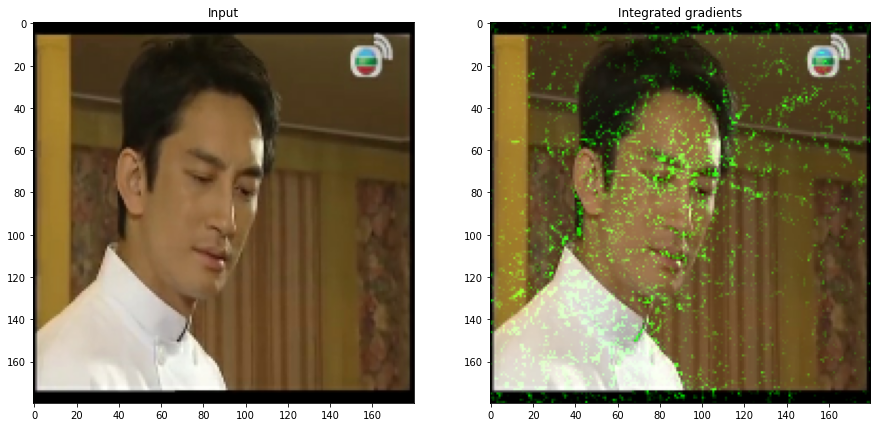

In [143]:
# 7. Process the gradients and plot
vis = GradVisualizer()
vis.visualize(
    image=orig_img,
    integrated_gradients=igrads.numpy(),
    clip_above_percentile=95,
    clip_below_percentile=28,
)

In [145]:
img = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/ML/CV/DATASET/Mei_Wei_Qing_Yuan/Actors_Images/Ma_You/ma10.jpg")

In [150]:
str(model.predict(np.expand_dims(img, axis=0)))

'[[0.33046824]]'